***
# Machine Learning Model: NCAA Men's March Madness

Each March, the NCAA Men's Basketball Tournament presents a uniquely complex modeling challenge: a single-elimination bracket format where team strength, matchup effects, conference dynamics, and randomness all converge. From a machine learning perspective, this is a high-variance, small-sample classification problem with deeply imbalanced priors and sparse head-to-head overlap — exactly the kind of domain where thoughtful feature engineering can meaningfully outperform brute-force modeling.

To that end, we've built a robust tournament-ready dataset from the ground up — integrating raw results, team metadata, and historical regular season play. Beyond box score statistics, we’ve derived a suite of advanced features: win/loss splits, opponent-adjusted metrics, and differential deltas — all computed at the team-season level and carried forward into each tournament matchup.

The goal now is to apply supervised learning techniques to model tournament outcomes through the following steps:

- Model Preparation  
- Baseline Model Predictions  
- Model Selection(s)
- Model Iterations:  
    - Logistic Regression  
    - XGBoost
- Model Evaluation
***

## Imports & Global Settings

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, classification_report, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import shap

from xgboost import XGBClassifier, XGBRegressor
from Utils import *

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
jimmer = 32 # Jimmer Fredette jersey number for randomizaion
duke = 1181 # TeamID for Duke to use for reference / debugging

In [5]:
tournament_df = pd.read_csv('./Data/Live/TournamentMatchupData.csv')

In [6]:
tournament_df.head()

,Season,DayNum,TeamScore,OppScore,Win,KenPomRank,OppKenPomRank,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_

In [7]:
tournament_df['TotalGames_delta']

0       1
1      -1
2      -1
3       0
4       1
       ..
2759    2
2760    3
2761   -3
2762    1
2763   -1
Name: TotalGames_delta, Length: 2764, dtype: int64

***
## Baseline Model Predictions

Before assessing the performance of any machine learning model, it's critical to establish a strong baseline: a simple, intuitive benchmark that represents what could be reasonably achieved with domain knowledge and a touch of luck.

In the context of the NCAA tournament, seeding reflects the selection committee’s composite view of team strength, informed by record, schedule, and a range of advanced metrics. As such, a natural baseline is to predict that the higher-seeded team will win each game. In the event that two teams share the same seed, regular season winning percentage will be used as a tie-breaker.

This rule-based approach offers more than just a coin flip; it represents a level of predictive accuracy that a well-informed observer might achieve without the help of machine learning. If our model can’t outperform this, we’ve added complexity without value. But if it can, there is a compelling case that the model is capturing signal beyond just chalk.

In [8]:
# Assuming lower seed ("higher ranked") team wins
tournament_df['BaselinePrediction'] = tournament_df['SeedNum'] < tournament_df['SeedNum_Opp']

# In the event two teams are the same Seed, the 'BaselinePrediction' is assigned to the team with the higher regular season winning %
tournament_df.loc[tournament_df["SeedNum"] == tournament_df["SeedNum_Opp"], 'BaselinePrediction'] = (
    tournament_df["WinningPercentage"] > tournament_df["WinningPercentage_Opp"]
)

# Convert to 0,1s
tournament_df['BaselinePrediction'] = tournament_df['BaselinePrediction'].astype(int)

In [9]:
# Get baseline score and accuracy for each season
baseline_scores = []

for season in tournament_df['Season'].unique():
    pred = tournament_df[tournament_df['Season'] == season]['BaselinePrediction']
    y = tournament_df[tournament_df['Season'] == season]['Win']

    score = accuracy_score(y, pred)
    score_ll = log_loss(y, pred)
    baseline_scores.append(score)

    print(f"Season: {season} | Accuracy {score:0.4f} | Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(baseline_scores):0.4f}")

Season: 2003 | Accuracy 0.6562 | Log Loss 12.3900
Season: 2004 | Accuracy 0.7344 | Log Loss 9.5741
Season: 2005 | Accuracy 0.6719 | Log Loss 11.8268
Season: 2006 | Accuracy 0.6719 | Log Loss 11.8268
Season: 2007 | Accuracy 0.7969 | Log Loss 7.3214
Season: 2008 | Accuracy 0.7656 | Log Loss 8.4477
Season: 2009 | Accuracy 0.7344 | Log Loss 9.5741
Season: 2010 | Accuracy 0.6719 | Log Loss 11.8268
Season: 2011 | Accuracy 0.6866 | Log Loss 11.2973
Season: 2012 | Accuracy 0.7015 | Log Loss 10.7593
Season: 2013 | Accuracy 0.6716 | Log Loss 11.8352
Season: 2014 | Accuracy 0.6343 | Log Loss 13.1801
Season: 2015 | Accuracy 0.7463 | Log Loss 9.1454
Season: 2016 | Accuracy 0.6716 | Log Loss 11.8352
Season: 2017 | Accuracy 0.7463 | Log Loss 9.1454
Season: 2018 | Accuracy 0.6716 | Log Loss 11.8352
Season: 2019 | Accuracy 0.6866 | Log Loss 11.2973
Season: 2021 | Accuracy 0.6970 | Log Loss 10.9223
Season: 2022 | Accuracy 0.6418 | Log Loss 12.9112
Season: 2023 | Accuracy 0.7015 | Log Loss 10.7593
Season

***
### Baseline Accuracy Evaluation
To ground our model evaluation to a meaningful reference point, we constructed a baseline predictor that mirrors a common heuristics-based approach:

- Pick the higher seed to win each matchup  
- In cases where both teams have the same seed, use regular season winning percentage as a tie-breaker

This logic provides a pragmatic and domain-informed benchmark — one that approximates the decisions of a reasonable fan or bracketologist.

When applied to historical NCAA tournament data from 2003–2024, this baseline achieved an average accuracy of approximately **69.7%**. While this level of performance is non-trivial — especially given the unpredictable nature of the tournament — it highlights the predictive value captured by seeding and regular season performance.

The goal of our machine learning models is to leverage deeper signals and patterns to exceed this 69.7% accuracy threshold.

Put differently, if our model fails to outperform this baseline, it's not offering any predictive value beyond what a moderately informed observer could achieve using simple heuristics.

This baseline will serve as a statistical litmus test for whether our model is truly extracting deeper signal from the data.
***


## Logisitc Regression
Let's start our modeling by implementing a logistic regression model — a foundational approach for binary classification problems. Despite its simplicity, logistic regression provides a strong interpretability baseline and often performs competitively when features are well-engineered.

It also serves as a useful diagnostic tool: if the logistic regression model struggles, it may point to noisy features or limited signal. If it performs well, it suggests the feature set contains strong predictive power, setting a meaningful benchmark for more sophisticated models to surpass.

***

In [10]:
tournament_df.head()

,Season,DayNum,TeamScore,OppScore,Win,KenPomRank,OppKenPomRank,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_

### Logistic Regression: Train/Test Split

Before training our model, we first need to split the data into training and testing sets to properly evaluate performance. However, prior to that, it's important to remove any columns that directly leak information about the target — features that are effectively proxies for the outcome we're trying to predict.

In [11]:
tournament_df.head()

,Season,DayNum,TeamScore,OppScore,Win,KenPomRank,OppKenPomRank,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_

In [12]:
drop_cols = [
'TeamScore',
'OppScore',
'Win',
'BaselinePrediction',
]

X = tournament_df.drop(columns=drop_cols)
y = tournament_df['Win']

# Split into train/test sets with 75/25 ratio
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=jimmer) # Jimmer!

In [13]:
# Pipeline steps
pipeline = Pipeline([
    ('normalise', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000, random_state=jimmer))
])

# Grid search parameters
param_grid = {
    'normalise': [StandardScaler(), None],
    'model__penalty': ['l2'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [ ]:
# # Grid search
# grid = GridSearchCV(pipeline, param_grid, cv=5)
# grid.fit(X_train, y_train)
# best_model = grid.best_estimator_

In [15]:
# Save best logisitic regression model
# joblib.dump(best_model, "./Models/best_logreg_model.pkl")

# # Load best logistic regression model
best_model = joblib.load("./Models/best_logreg_model.pkl")

In [16]:
# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_proba_test = best_model.predict_proba(X_test)[:, 1]

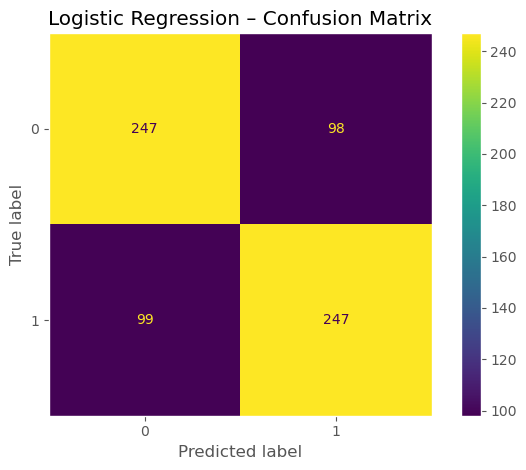

In [17]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Logistic Regression – Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [18]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print(f"Recall:     Train {recall_score(y_train, y_pred_train):.3f} | Test {recall_score(y_test, y_pred_test):.3f}")
print(f"Precision:  Train {precision_score(y_train, y_pred_train):.3f} | Test {precision_score(y_test, y_pred_test):.3f}")
print(f"Accuracy:   Train {accuracy_score(y_train, y_pred_train):.3f} | Test {accuracy_score(y_test, y_pred_test):.3f}")
print(f"F1 Score:   Train {f1_score(y_train, y_pred_train):.3f} | Test {f1_score(y_test, y_pred_test):.3f}")
print(f"AUC Score:  Train {roc_auc_score(y_train, y_proba_train):.3f} | Test {roc_auc_score(y_test, y_proba_test):.3f}")
print(f"False Pos.: Train {false_positive_rate(y_train, y_pred_train):.3f} | Test {false_positive_rate(y_test, y_pred_test):.3f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       345
           1       0.72      0.71      0.71       346

    accuracy                           0.71       691
   macro avg       0.71      0.71      0.71       691
weighted avg       0.71      0.71      0.71       691

Recall:     Train 0.726 | Test 0.714
Precision:  Train 0.729 | Test 0.716
Accuracy:   Train 0.728 | Test 0.715
F1 Score:   Train 0.728 | Test 0.715
AUC Score:  Train 0.809 | Test 0.795
False Pos.: Train 0.269 | Test 0.284


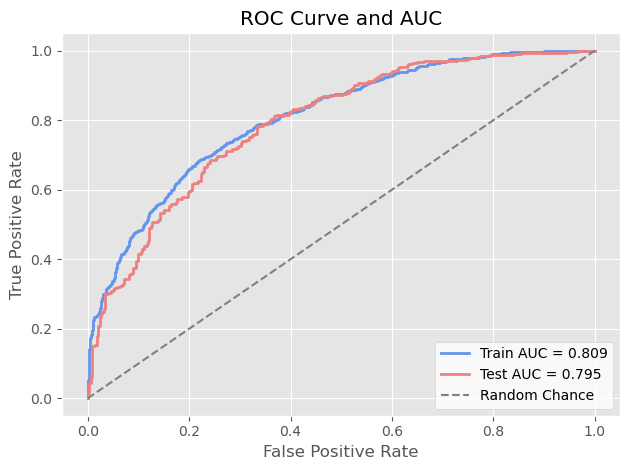

AUC (Train): 0.8087
AUC (Test):  0.7947


In [18]:
# Compute ROC curve and AUC using predicted probabilities
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, color='cornflowerblue', label=f"Train AUC = {auc_train:.3f}", lw=2)
plt.plot(fpr_test, tpr_test, color='lightcoral', label=f"Test AUC = {auc_test:.3f}", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve and AUC")
plt.legend(loc="lower right", facecolor="white")

plt.tight_layout()
plt.show()

print(f"AUC (Train): {auc_train:.4f}")
print(f"AUC (Test):  {auc_test:.4f}")


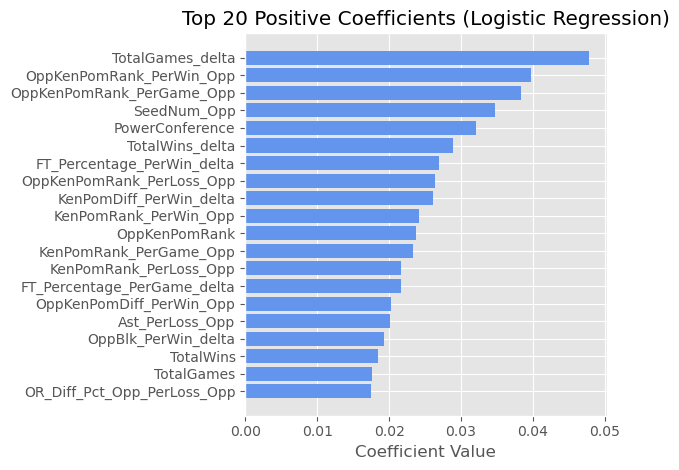

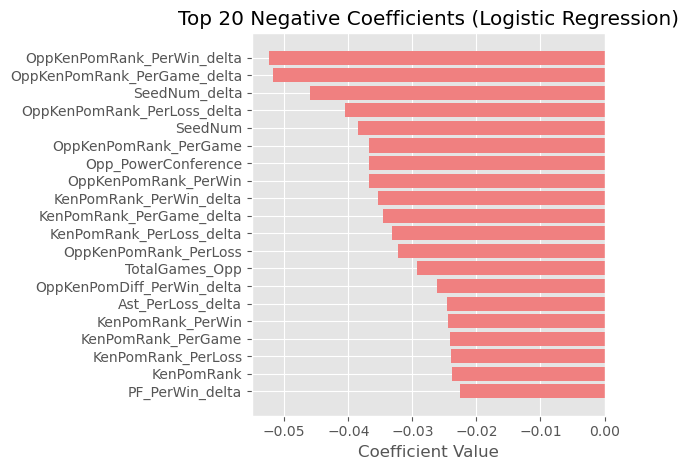

In [19]:
# Extract logistic regression model from pipeline
logreg_model = best_model.named_steps['model']

# Extract feature names and coefficients
features = X_train.columns
coefs = logreg_model.coef_[0] 

# Create DataFrame for coefs
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefs})

# Top N positive and negative coefficients
n = 20
top_pos = coef_df[coef_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(n)
top_neg = coef_df[coef_df['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(n)

# Plot: Top Positive Coefficients
plt.figure()
plt.barh(top_pos['Feature'][::-1], top_pos['Coefficient'][::-1], color='cornflowerblue')
plt.title(f"Top {n} Positive Coefficients (Logistic Regression)")
plt.xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

# Plot: Top Negative Coefficients
plt.figure()
plt.barh(top_neg['Feature'][::-1], top_neg['Coefficient'][::-1], color='lightcoral')
plt.title(f"Top {n} Negative Coefficients (Logistic Regression)")
plt.xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

***
### Logistic Regression: Interpreting Key Features

Our logistic regression model highlights a range of performance, opponent, and context features that influence tournament outcomes. Rather than focusing on raw coefficients, we’ve grouped the most predictive variables into thematic categories that reveal how teams gain an edge — or fall behind — in March Madness.

Both positive and negative coefficients play critical roles:
- **Positive coefficients** increase the probability of winning.
- **Negative coefficients** decrease win probability.

By grouping features thematically, we can see clear patterns emerge.

**1. Opponent Quality & Strength of Schedule**

- Features like `OppKenPomRank_PerGame_Opp`, `OppKenPomRank_PerWin_Opp`, and `SeedNum_Opp` rank highly.
- Facing weaker opponents (higher KenPom ranks, higher seeds) increases win probability.
- Conversely, opponent strength deltas like `OppKenPomRank_PerWin_delta` and `OppKenPomRank_PerGame_delta` show that tougher matchups (stronger opponents) meaningfully lower chances of winning.
- The model heavily leans on opponent quality — especially when relative to your own team’s strength.

**2. KenPom Metrics & Strength Differential**

- KenPom-derived features (`KenPomRank_PerWin_delta`, `KenPomDiff_PerGame_delta`, etc.) are consistently predictive.
- Stronger teams (lower KenPom ranks and favorable differentials) are more likely to win.
- Negative coefficients on `KenPomRank_PerGame_delta` and `KenPomDiff_PerWin_delta` reinforce the inverse: teams disadvantaged in KenPom-adjusted strength are less likely to win.

**3. Efficiency Gaps: Shooting & Ball Movement**

- `FT_Percentage_PerWin_delta` and `OppBlk_PerWin_delta` show that even marginal gaps in shooting efficiency and rim protection matter.
- Opponent passing metrics like `Ast_PerLoss_Opp` indicate that facing teams with weaker ball movement is advantageous.

**4. Schedule & Experience Proxies**

- `TotalGames_delta` and `TotalWins_delta` rank among the top positive coefficients.
- These metrics largely reflect structural factors: teams from power conferences typically play longer schedules due to larger leagues and more extensive non-conference slates, enabled by better resources and scheduling flexibility.
- Rather than indicating inherent team quality, these features capture underlying differences in program scale and structure.
- Similarly, `TotalGames_Opp` appears as a negative coefficient — when facing teams from these larger programs with fuller schedules, matchups become more difficult.


**Summary Takeaways**

- **Opponent quality dominates.** Matchup strength and relative deltas in KenPom metrics are central to predicting tournament success.
- **KenPom differential is validated.** The gap between a team and its opponent in efficiency and overall quality is a powerful signal.
- **Schedule proxies like TotalGames matter more than expected.** These features capture important contextual information about team readiness and competitive environment.
- **Subtle efficiency gaps accumulate.** Free throw accuracy, ball movement, rim protection — all stack the odds in tight games.
- **Relative metrics outperform raw stats.** Delta features consistently rise to the top, validating our feature engineering approach.

This thematic view makes clear that the model captures both basketball fundamentals and advanced matchup dynamics, providing a well-rounded foundation for prediction.

***
### Model Evaluation Summary: Logistic Regression

Our logistic regression model establishes a strong, well-calibrated baseline for NCAA tournament prediction. Performance is consistent across both training and test sets, showing no signs of overfitting and good generalization.

Importantly, The model achieved a **test accuracy of ~71.5%** versis the naive "chalk" baseline of picking higher-seeded teams (~69.7%), validating the signal captured by our engineered features.

The AUC score (~0.80) is particularly notable: it reflects the model’s ability to rank actual winners higher than losers roughly 80% of the time — an impressive result given the tournament’s inherent unpredictability.

#### Performance Summary

| Metric          | Train Set | Test Set |
|-----------------|-----------|----------|
| Accuracy        | 0.728     | 0.715    |
| Precision       | 0.729     | 0.716    |
| Recall          | 0.726     | 0.714    |
| F1 Score        | 0.728     | 0.715    |
| AUC Score       | 0.809     | 0.795    |
| False Pos. Rate | 0.269     | 0.284    |

### Key Takeaways

- **Test accuracy of ~71.5%** beats the naive seed-based baseline, confirming meaningful signal in our features.
- **Strong AUC performance.** High discrimination power between winners and losers, even in tightly contested matchups.
- **Balanced generalization.** Close alignment between train and test sets indicates good model robustness and minimal overfitting.

With this strong logistic regression benchmark in place, we are well-positioned to advance to more complex models — beginning with XGBoost.

***
## XGBoost Model

XGBoost is a powerful ensemble learning method based on gradient-boosted decision trees. Unlike linear models such as logistic regression, XGBoost can model complex, nonlinear relationships and interactions between features.

In the context of NCAA tournament prediction, where matchups hinge on subtle differences in team strength, playing style, and statistical nuance, XGBoost offers a flexible framework to capture patterns that may not be linearly separable. We'll train and evaluate an XGBoost model using the same feature set and metrics, allowing for a direct comparison to our logistic regression model.
***

In [36]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=jimmer, n_jobs=1))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0]
}

In [ ]:
# Grid Search
# grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=5)
# grid.fit(X_train, y_train)
# best_model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [20]:
# Save best XGBoost model
# joblib.dump(best_model, "./Models/best_XGB_model.pkl")

best_model = joblib.load("./Models/best_XGB_model.pkl")

In [21]:
# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_proba_test = best_model.predict_proba(X_test)[:, 1]

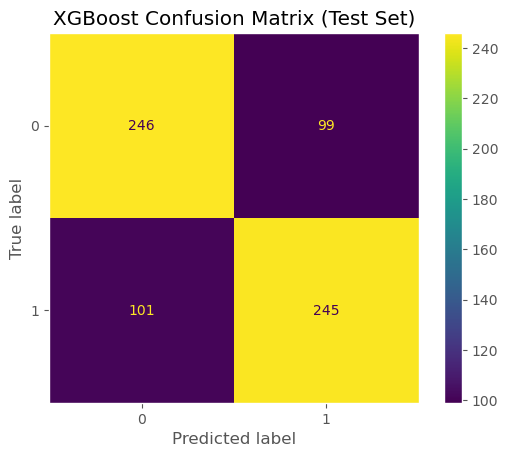

In [22]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

In [23]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Metrics
print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Accuracy (Test):  {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC AUC (Train):  {roc_auc_score(y_train, y_proba_train):.3f}")
print(f"ROC AUC (Test):   {roc_auc_score(y_test, y_proba_test):.3f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       345
           1       0.71      0.71      0.71       346

    accuracy                           0.71       691
   macro avg       0.71      0.71      0.71       691
weighted avg       0.71      0.71      0.71       691

Accuracy (Train): 0.748
Accuracy (Test):  0.711
ROC AUC (Train):  0.850
ROC AUC (Test):   0.798


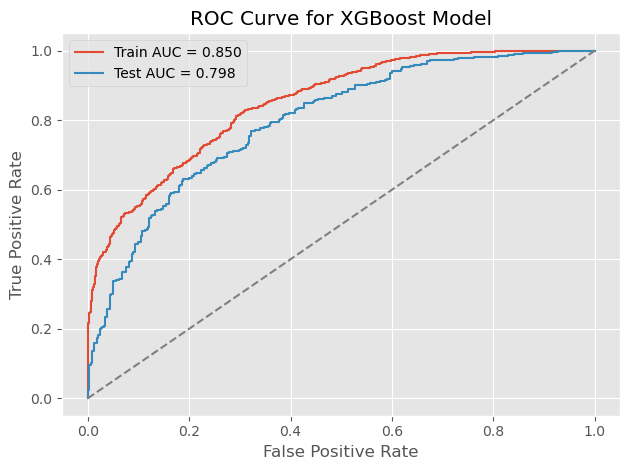

In [24]:
# ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_score(y_train, y_proba_train):.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_score(y_test, y_proba_test):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")

plt.legend()
plt.tight_layout()
plt.show()

***
### Model Evaluation Summary: XGBoost

After tuning hyperparameters with grid search, our XGBoost model delivers competitive performance in predicting NCAA tournament outcomes.

Overall, the model performs well given the noisy and high-variance nature of tournament games. With an accuracy above 71% and an AUC score approaching 0.80, the model effectively distinguishes winners from losers, improving on our logistic regression baseline.

#### Performance Summary

| Metric                | Train Set | Test Set |
|-----------------------|-----------|----------|
| Accuracy              | 0.748     | 0.711    |
| ROC AUC               | 0.850     | 0.798    |
| Precision             | ~0.71     | ~0.71    |
| Recall                | ~0.71     | ~0.71    |
| F1 Score              | ~0.71     | ~0.71    |

#### Key Insights

- **Accuracy of 71.1%** is roughly in line with prior models and exceeds the naive higher-seed baseline.
- The model maintains **strong discrimination** power, with an AUC of ~0.80 on the test set — indicating the model assigns a higher probability to actual winners around 80% of the time.
- **Precision, Recall, and F1 Score** are balanced across classes, meaning the model is not overly biased toward favorites or underdogs.
- **Train-Test gap** is reasonable, with slight overfitting as expected given data size — but generalization holds well.
- These results validate both the feature engineering approach and the utility of non-linear modeling techniques like XGBoost over simpler baselines.

Let's examine the feature importanances before exploring further interpretable ML approaches (SHAP) and unsupervised learning techniques.

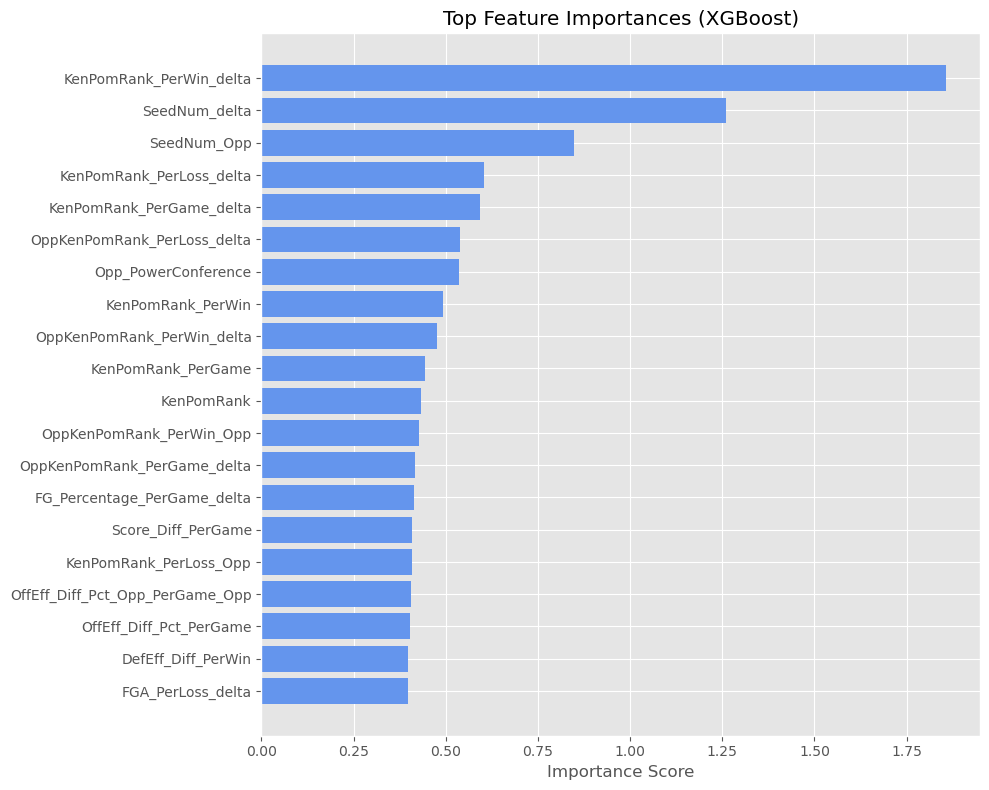

In [25]:
importances = best_model.named_steps['model'].feature_importances_ * 100
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


# Top N features
n = 20
top_features_df = importance_df.head(n)

plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'][::-1], top_features_df['Importance'][::-1], color='cornflowerblue')
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

***
### XGBoost Feature Importance Summary

Our feature importance analysis reveals a clear pattern: KenPom-derived metrics overwhelmingly drive model predictions.

**1. KenPom Metrics Dominate**

- Relative gaps (`KenPomRank_PerWin_delta`, `KenPomRank_PerLoss_delta`, etc.) are the most influential features. Teams outperforming their opponents in KenPom ratings have a significantly higher win probability.
- Raw KenPom rankings also matter. Team strength and opponent weakness, as captured by KenPom, consistently rise to the top.
- Opponent KenPom metrics further emphasize that tournament outcomes hinge not just on team quality but also the strength of the opposition.

**2. Seeding and Conference Strength**

- Features like `SeedNum_delta`, `SeedNum_Opp`, and `Opp_PowerConference` reinforce the predictive value of tournament seeding and conference affiliation, even in a model dominated by advanced efficiency metrics.
- These variables capture structural advantages, such as strength of schedule and program pedigree.

**3. Efficiency Gaps**

- Shooting and offensive efficiency differentials (`FG_Percentage_PerGame_delta`, `OffEff_Diff_Pct_PerGame`) provide additional explanatory power.
- While secondary to overall team strength, these metrics help differentiate closely matched teams.

**Key Takeaways**

- KenPom ratings and differentials are foundational to the model’s predictive power, validating their use in feature engineering.
- Traditional indicators like seeding and conference affiliation remain strong, complementary signals.
- Efficiency gaps supplement overall team quality, capturing the nuance in head-to-head matchups.
***

### Model Comparison: Logistic Regression vs. XGBoost

With both models trained and evaluated, we can now compare performance across key metrics.

#### Performance Summary

| Metric            | Logistic Regression | XGBoost |
|-------------------|--------------------|---------|
| Accuracy (Train)  | 0.728              | 0.748   |
| Accuracy (Test)   | 0.715              | 0.711   |
| ROC AUC (Train)   | 0.809              | 0.850   |
| ROC AUC (Test)    | 0.795              | 0.798   |
| Precision (Test)  | 0.716              | 0.716   |
| Recall (Test)     | 0.714              | 0.714   |
| F1 Score (Test)   | 0.715              | 0.715   |
| False Pos. Rate   | 0.284              | 0.284   |

#### Observations

- **Discrimination Power**: XGBoost slightly edges out logistic regression on **AUC** (~0.798 vs. ~0.795). Both models are strong at distinguishing winners from losers, with XGBoost providing a marginal improvement.
  
- **Accuracy & F1**: Surprisingly, accuracy and F1 scores are nearly identical across both models (~71%). Logistic regression generalizes just as well as XGBoost on test data.

- **Train-Test Gap**: XGBoost shows a wider gap between train and test ROC AUC (0.850 vs. 0.798), hinting at slight overfitting.

- **Precision & Recall**: Both models are balanced across classes, which is expected in a 50/50 class split dataset like this tournament framing.

#### Takeaways

- **Both models perform at a similar level**, with XGBoost offering modest improvement in discriminative power (AUC) but not a substantial jump.
- **Logistic regression proves a reliable baseline**, providing robust, interpretable results with simpler structure and faster compute time.
- **XGBoost’s marginal gains** come at higher complexity and longer training time. However, its potential to capture non-linear patterns makes it valuable for future iterations, especially as we expand feature sets.

Both models provide a strong foundation. Moving forward, we’ll prioritize **interpretability (Logistic Regression)** alongside **advanced interpretability tools (e.g., SHAP) for XGBoost** to extract deeper insights from the tournament predictions.


***
## Interpretable ML: SHAP Values (XGBoost)

To better understand our XGBoost model’s decisions, we’ll use **SHAP (SHapley Additive exPlanations)** — a game-theoretic approach that explains the contribution of each feature to individual predictions.

Unlike simple feature importance, SHAP values tell us:

- The direction of impact (whether a feature pushes the prediction towards a win or a loss).
- The magnitude of the contribution for each feature.
- Both global (overall feature impact) and local (single prediction) explanations.

Given XGBoost’s complex tree structure, SHAP helps uncover why the model assigns certain probabilities — providing transparent, interpretable insights.

Let's compute and visualize SHAP values for our model.

***

In [38]:
# Extract fitted XGBoost model from pipeline
xgb_model = best_model.named_steps['model']

# Prepare scaled data (since pipeline includes StandardScaler)
X_scaled = best_model.named_steps['scaler'].transform(X_train)

# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_scaled)

# Compute SHAP values
shap_values = explainer(X_scaled)

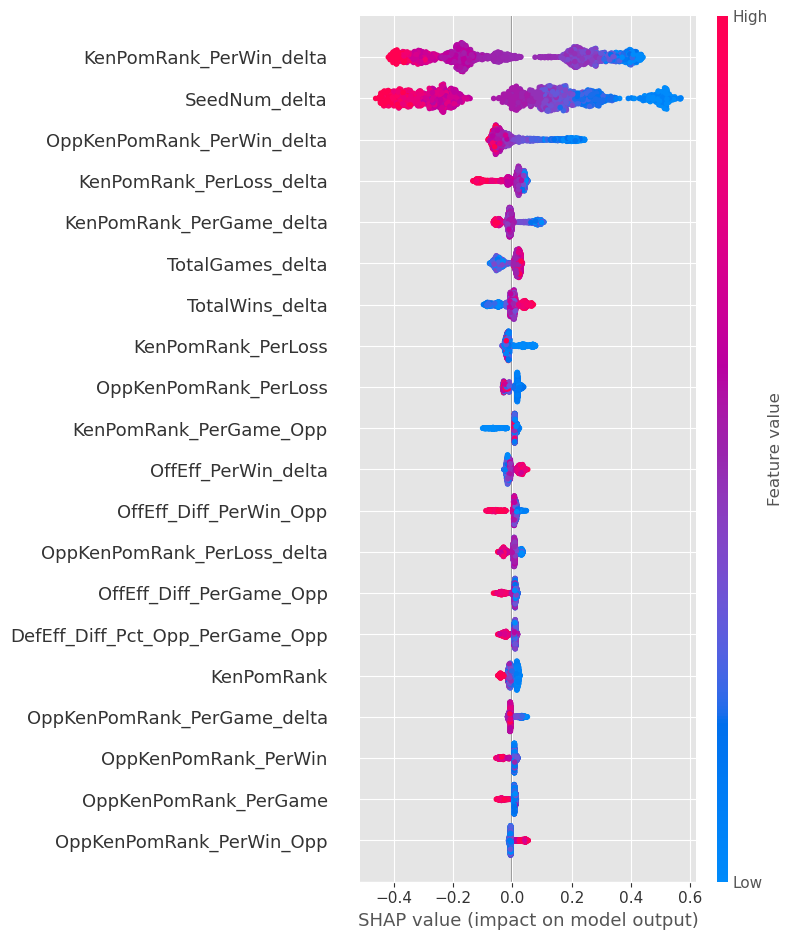

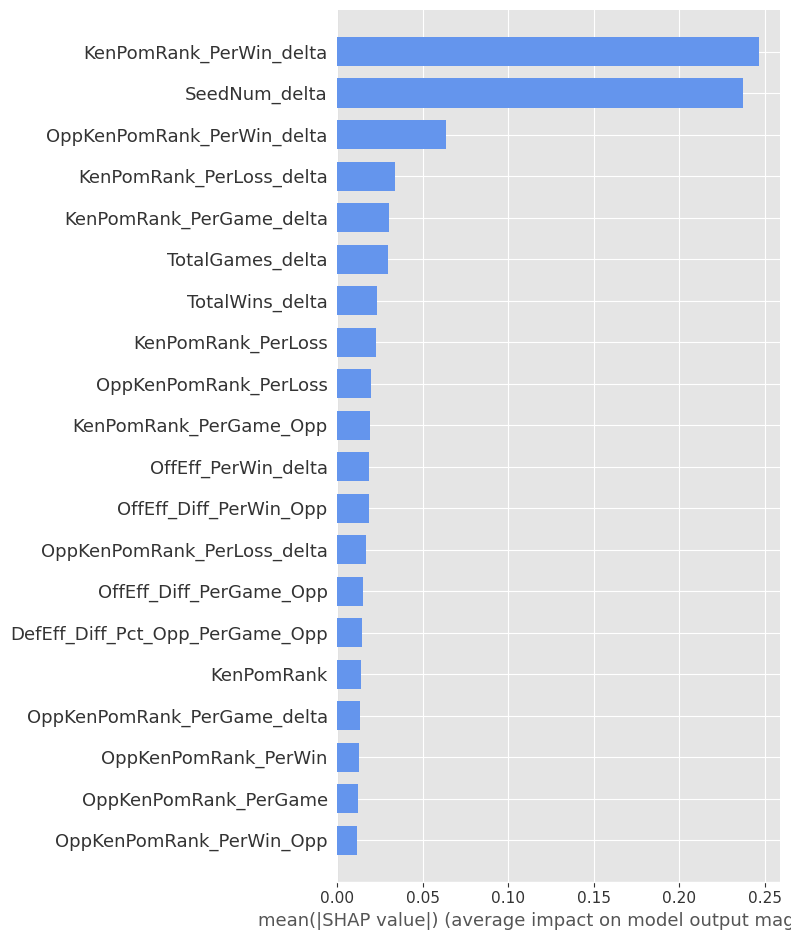

In [39]:
# Summary plot: Global feature importance
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

# Bar plot for mean absolute SHAP values
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar", color='cornflowerblue')

***
### Dependency Plots

Another way to use Shapley values for global interpretation is to look at the Shapley Dependence Plots.
***

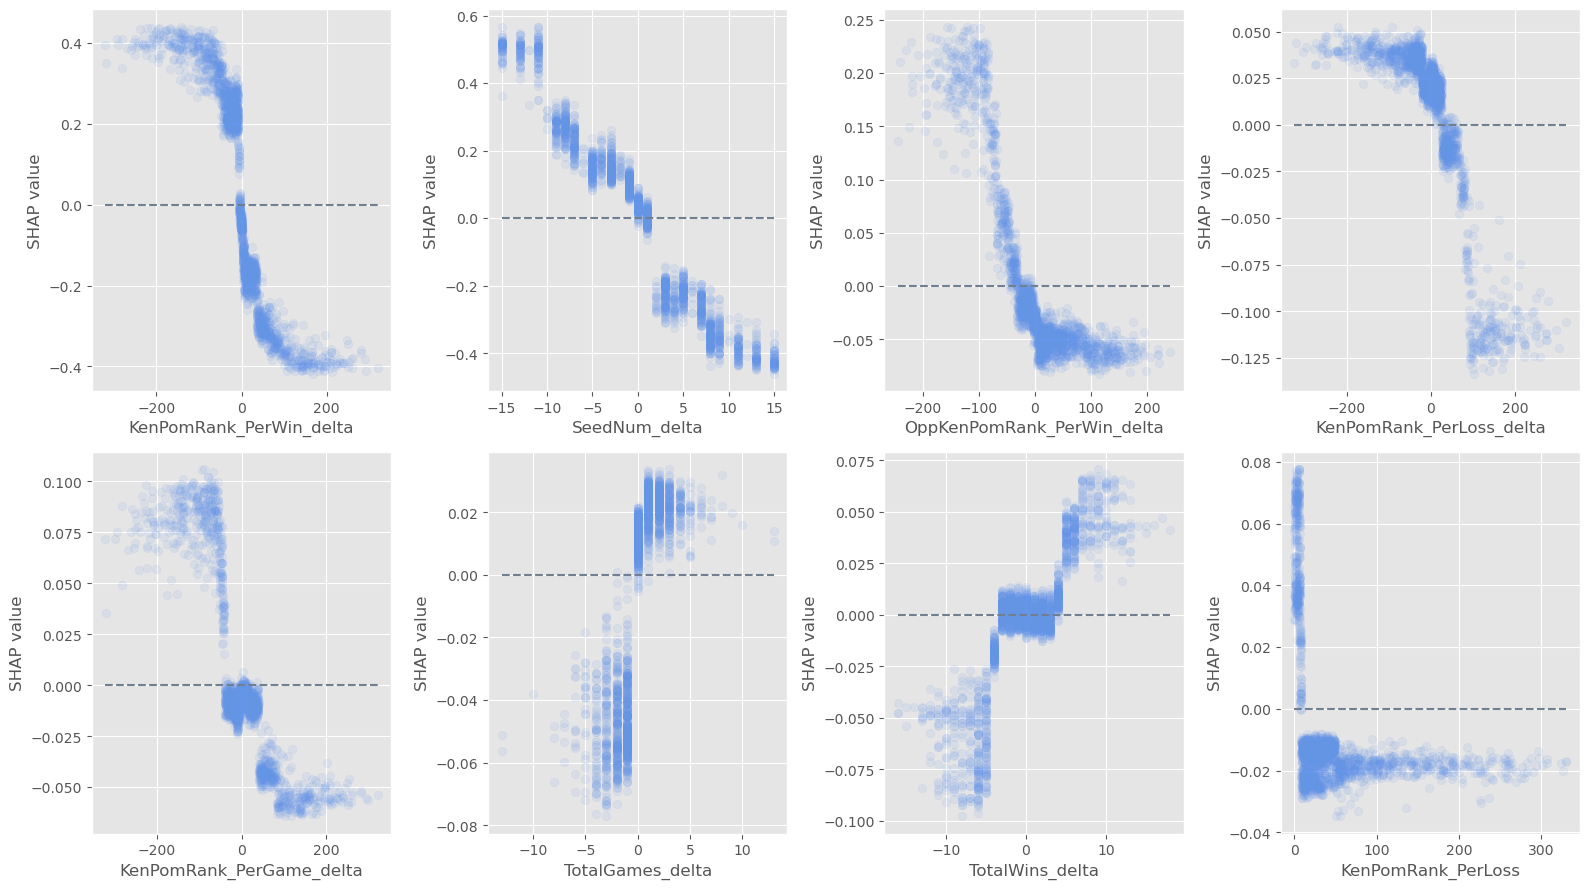

In [36]:
# Create DataFrame for Shapley values easier plotting
shap_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# Top N features
top_n = 8
top_features = shap_df.abs().mean().sort_values(ascending=False).head(top_n).index

# Set up grid
plt.figure(figsize=(16, 9))

for i, col in enumerate(top_features):
    plt.subplot(2, 4, i + 1)  # now safe: i+1 <= 8
    plt.scatter(X_train[col], shap_df[col], alpha=0.1, color='cornflowerblue')
    plt.hlines(y=0, xmin=X_train[col].min(), xmax=X_train[col].max(), colors='slategray', linestyles='--')
    plt.xlabel(col)
    plt.ylabel('SHAP value')

plt.tight_layout()
plt.show()

***
### SHAP Value Interpretation

**1) Delta Features Dominate**  
The top features are all `_delta` variables, confirming that relative matchup strength matters more than raw stats.

**2) KenPom Metrics Lead**  
KenPom deltas, especially `KenPomRank_PerWin_delta`, are the strongest predictors. Efficiency gaps between teams clearly drive model predictions.

**3) Seeding Differential is High-Signal**  
`SeedNum_delta` strongly influences predictions, confirming the value of tournament seeding.

**4) Schedule Features Matter, but Less**  
`TotalGames_delta` and `TotalWins_delta` show some importance, likely reflecting strength of schedule and program caliber.

**5) Directionality is Logical**  
Higher positive deltas (better team, weaker opponent) increase win probability. Dependence plots confirm this clean relationship.
***